In [150]:
%matplotlib inline   



import warnings
warnings.filterwarnings("ignore") 

from abipy import abilab
import os
import abipy.flowtk as flowtk
import abipy.data as abidata

def make_scf_nscf_inputs():
    """Build ands return the input files for the GS-SCF and the GS-NSCF tasks."""
    multi = abilab.MultiDataset(structure=abidata.cif_file("si.cif"),
                                pseudos=abidata.pseudos(r"/home/varre/14si.psp"), ndtset=2)
    #14si.psp for lda
    #Si-GGA.psp8 for gga

    # Set global variables (dataset1 and dataset2)
    multi.set_vars(ecut=12, nband=10 ,ixc=11,usekden =0,getwfk = -1)

    # Dataset 1 (GS-SCF run)
    multi[0].set_kmesh(ngkpt=[8,8,8], shiftk=[0,0,0])
    multi[0].set_vars(tolvrs=1e-6)

    # Dataset 2 (GS-NSCF run on a k-path)
    kptbounds = [
        [0.3750000000 ,0.3750000000 ,0.7500000000],#K  
        [0.00000000 ,0.0000000 ,0.00000000],#Γ
        [0.50000000 ,0.50000000 ,0.500000000],#L
        [0.50000000 ,0.250000000 ,0.7500000000],#W
        [0.50000000 ,0.0000000 ,0.500000000],#X
    ]

    multi[1].set_kpath(ndivsm=6, kptbounds=kptbounds)
    multi[1].set_vars(tolwfr=1e-06)
    
    # Return two input files for the GS and the NSCF run
    scf_input, nscf_input = multi.split_datasets()
    return scf_input, nscf_input



In [151]:
scf_input, nscf_input = make_scf_nscf_inputs()

workdir = "/home/varre/siband"
flow = flowtk.bandstructure_flow(workdir, scf_input, nscf_input)

In [152]:
flow.show_status()


Work #0: <BandStructureWork, node_id=454, workdir=siband/w0>, Finalized=False
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| Task   | Status      | Queue   | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time   |   Node_ID |
+========+=============+=========+==============+============+==========+=================+========+===========+
| w0_t0  | Initialized | None    | 1|  1|2.0    | 1|  2      | ScfTask  | (0, 0, 0)       | None   |       455 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| w0_t1  | Initialized | None    | 1|  1|2.0    | 3|  6      | NscfTask | (0, 0, 0)       | None   |       456 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+



In [153]:
if os.path.isdir("/home/varre/siband"): 
    import shutil
    shutil.rmtree("/home/varre/siband")

flow.build_and_pickle_dump()

0

In [154]:
for p in flow[0][0].input.pseudos: 
    print(p)

<NcAbinitPseudo: 14si.psp>
  summary: Si  Fri Oct 08 11:18:59 1993
  number of valence electrons: 4.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 1.7
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


In [155]:
flow[0][0].input

<AbinitInput at 139845082473328>

In [156]:
flow[0][0].input.structure

Structure Summary
Lattice
    abc : 3.86697462 3.86697462 3.86697462
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 40.88829179346891
      A : 3.3488982567096763 0.0 1.9334873100000005
      B : 1.1162994189032256 3.1573715557642927 1.9334873100000005
      C : 0.0 0.0 3.86697462
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (1.1163, 0.7893, 1.9335) [0.2500, 0.2500, 0.2500]

In [157]:
print([task.input["kptopt"] for task in flow.iflat_tasks()])


[1, -4]


In [158]:
flow.make_scheduler().start()

Using scheduler v>=3.0.0


[Thu Aug  5 10:51:00 2021] Number of launches: 1

Work #0: <BandStructureWork, node_id=454, workdir=siband/w0>, Finalized=False
+--------+-------------+--------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status      | Queue        | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+=============+==============+==============+============+==========+=================+==========+===========+
| w0_t0  | Submitted   | 193530@local | 1|  1|2.0    | 0|  0      | ScfTask  | (1, 0, 0)       | 0:00:00Q |       455 |
+--------+-------------+--------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Initialized | None         | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None     |       456 |
+--------+-------------+--------------+--------------+------------+----------+-----------------+----------+-----------+

[Thu Aug  5 10:51:11 2021] Numb

0

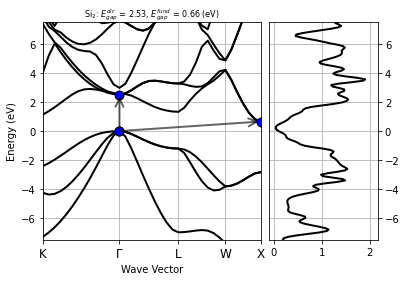

In [159]:
with flow[0][0].open_gsr() as gsr:
    ebands_kmesh = gsr.ebands
    
with flow[0][1].open_gsr() as gsr:
    gsr.ebands.plot_with_edos(ebands_kmesh.get_edos(), with_gaps=True);